*El objetivo es chequear la calidad del dato*

Customizando el color del texto en el *print*:

In [1]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [2]:
#Evitar alertas
import warnings
warnings.filterwarnings('ignore')
#Consultando el database en mysql
import pymysql
#Trabajar con dataframes
import pandas as pd
#Gráficas
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.colors as mcolors
import seaborn as sns
sns.set_theme(style="whitegrid")
#Herramienta en estadística
import numpy as np

Dando un vistazo a 10 filas de forma aleatoria:

In [ ]:
connection = pymysql.connect(host="127.0.0.1",user='root',charset='utf8mb4',db= "viviendas_bcn",cursorclass=pymysql.cursors.DictCursor)
query="SELECT * FROM `viviendas_bcn`.`kaggle`;"
data = pd.read_sql(query, connection)
data.iloc[np.random.randint(0,data.shape[0],10),:]

,id,price,rooms,bathroom,lift,terrace,square_meters,real_state,neighborhood,square_meters_price
2026,2027,1290,3,2,True,False,70,flat,Ciutat Vella,18.4286
3296,3297,850,1,1,True,False,48,None,Ciutat Vella,17.7083
38,39,852,4,1,True,False,75,flat,Sants-Montjuïc,11.3600
4282,4283,750,1,1,False,False,47,flat,Sants-Montjuïc,15.9574
5828,5829,5500,3,2,True,False,100,None,Gràcia,55.0000
2951,2952,1050,2,2,True,False,65,flat,Sant Martí,16.1538
3497,3498,1150,4,2,True,False,91,flat,Les Corts,12.6374
4825,4826,700,2,1,True,False,66,flat,Horta- Guinardo,10.6061
3237,3238,1200,3,2,True,False,102,flat,Ciutat Vella,11.7647
1835,1836,900,1,1,True,True,34,flat,Gràcia,26.4706


Viendo que la primera columna solo brinda información sobre la posición de las filas. Por tanto, se procede a eliminar dicha columna:

In [4]:
data.drop("id",inplace=True,axis=1)

In [5]:
f,c =data.shape
print(color.PURPLE +color.BOLD + color.UNDERLINE +'viviendas:'+ color.END,f'{f} filas y {c} columnas')

viviendas: 8188 filas y 9 columnas


Viendo los tipos de variable:

In [6]:

for i,attr in enumerate(data.columns.tolist(),start=1):
    dtype= data[attr].dtype
    if dtype == "str":
        print(color.YELLOW+color.BOLD +f'{i:>2}.{attr:<20} {dtype}'+color.END)
    elif dtype == "int64":
        print(color.RED+color.BOLD +f'{i:>2}.{attr:<20} {dtype}'+color.END)
    elif dtype == "bool":
        print(color.DARKCYAN+color.BOLD +f'{i:>2}.{attr:<20} {dtype}'+color.END)
    else:
        print(color.BLUE+color.BOLD +f'{i:>2}.{attr:<20} {dtype}'+color.END)     

 1.price                int64
 2.rooms                int64
 3.bathroom             int64
 4.lift                 object
 5.terrace              object
 6.square_meters        int64
 7.real_state           object
 8.neighborhood         object
 9.square_meters_price  float64


Checkeando valores nulos:

In [7]:
data.isnull().sum()

price                    0
rooms                    0
bathroom                 0
lift                     0
terrace                  0
square_meters            0
real_state             268
neighborhood             0
square_meters_price      0
dtype: int64

#### Tipos de viviendas por distrito

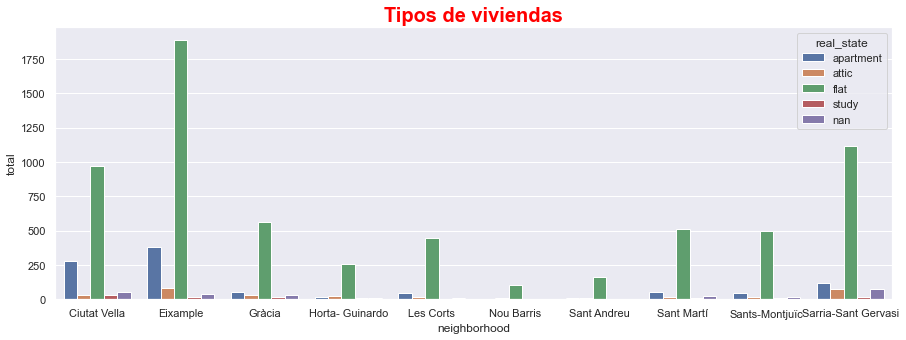

In [9]:
columnas=["neighborhood","real_state","price"]
viviendas=data[columnas].groupby(["neighborhood","real_state"],dropna=False,as_index=False).count()
viviendas.rename(columns={"price":"total"},inplace=True)
viviendas.fillna("nan",inplace=True)
sns.barplot(x="neighborhood",hue="real_state",y="total",data=viviendas)
sns.set_theme(rc={'figure.figsize':(15,5)})
plt.title("Tipos de viviendas",color="red",fontweight="bold",size=20)
plt.show()

Se verifica unanimamente que la moda en todos los distritos es *flat*. Por tanto, se reemplazará los valores nulos con ese valor categórico:

In [10]:
data.fillna("flat",inplace=True)

##### Verificación de los precios
El objetivo es chequear que el precio establecido sea aproximadamente igual al precio_m² X m²

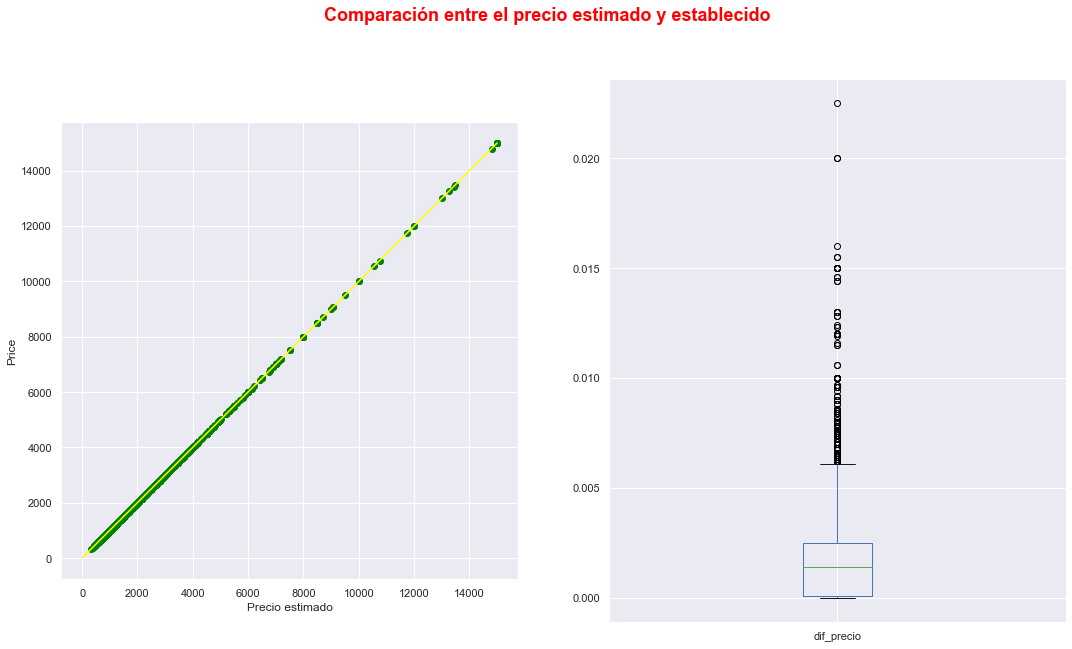

In [11]:
data["precio_est"] = data.square_meters*data.square_meters_price
data["dif_precio"] = abs(data.precio_est-data.price)
plt.figure(figsize=(18,10))
ax1=plt.subplot(121)
plt.scatter(x=data.precio_est,y=data.price,color="green")
plt.plot(range(data.price.max()),range(data.price.max()),color="yellow")
ax1.axis("scaled")
ax1.set(xlabel="Precio estimado",ylabel="Price")
ax2=plt.subplot(122)
data.dif_precio.plot.box()
plt.suptitle("Comparación entre el precio estimado y establecido",fontsize=18,fontweight="bold",color="red")
plt.show()


Se comprueba que ambos precios son coherentes.
Se procede a eliminar `precio_est` y `dif_precio`: 

In [12]:
data.drop(["precio_est","dif_precio"],axis=1,inplace=True)

### Análisis de correlación
En el primer análisis se omite `price` 

[]

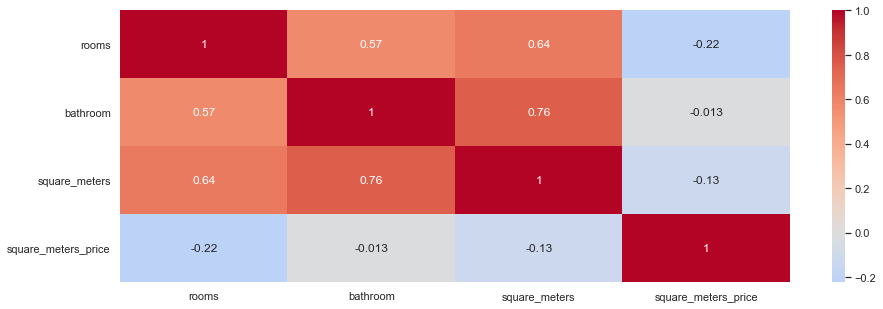

In [13]:
correlacion=data.drop("price",axis=1).corr()
sns.heatmap(correlacion, annot=True, cmap="coolwarm", center=0)
plt.plot()

- Se observa que el coeficiente de correlación entre `square_meters` y `bathroom` es alto. Por tanto, se puede excluir `bathroom` en el diseño de modelos de predicción.
- Se debe de omitir los análisis a los atributos que provienen de boleanas.

## Análisis por atributo
El objetivo es graficar cada atributo respecto a `price` de acuerdo al tipo de variable del atributo en dos gráficos en una columna, donde el pie del gráfico se añade el coeficiente de correlación.

**Programa auxiliar:**


In [14]:
# Tranformar variables categóricas a numéricas 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# Gráficos por atributo y price
def analisis(attr):
    variables_counted=data[attr].value_counts(dropna=False,ascending=True).sort_index()
    variables_counted_df =pd.DataFrame({"x":variables_counted.index,"y":variables_counted.values})
    dtype= data[attr].dtype
    plt.figure(figsize=(18,10))
    #Primer gráfico
    ax1=plt.subplot(211)
    if (dtype== "float64") or (dtype=="int64" and variables_counted.size>30):
        sns.histplot(data=data[attr],bins=100)
        ax1.set(xlabel="",ylabel="")
        #Segundo gráfico
        ax2=plt.subplot(212,sharex=ax1)
        sns.scatterplot(data=data,x=attr,y="price")
    else:
        sns.barplot(data=variables_counted_df,x="x",y="y")
        ax1.set(xlabel="",ylabel="")
        #Segundo gráfico
        ax2=plt.subplot(212,sharex=ax1)
        sns.boxplot(data=data,y='price',x=attr)
    plt.suptitle(attr.capitalize(),fontsize=18,fontweight="bold",color="red")
    plt.show()
    #Coeficiente de correlación ( se excluye lift y terrace) 
    if not(attr=="lift" or attr=="terrace"):
        df= data[[attr,'price']]
        if dtype == 'object':
            df[attr]=le.fit_transform(df[attr])
        corr=df.corr().iloc[0,1]
        print(color.PURPLE+ 'CORRELACIÓN:'+ color.END + f' {attr} y price: {round(corr,2)}')
    

### Neighborhood

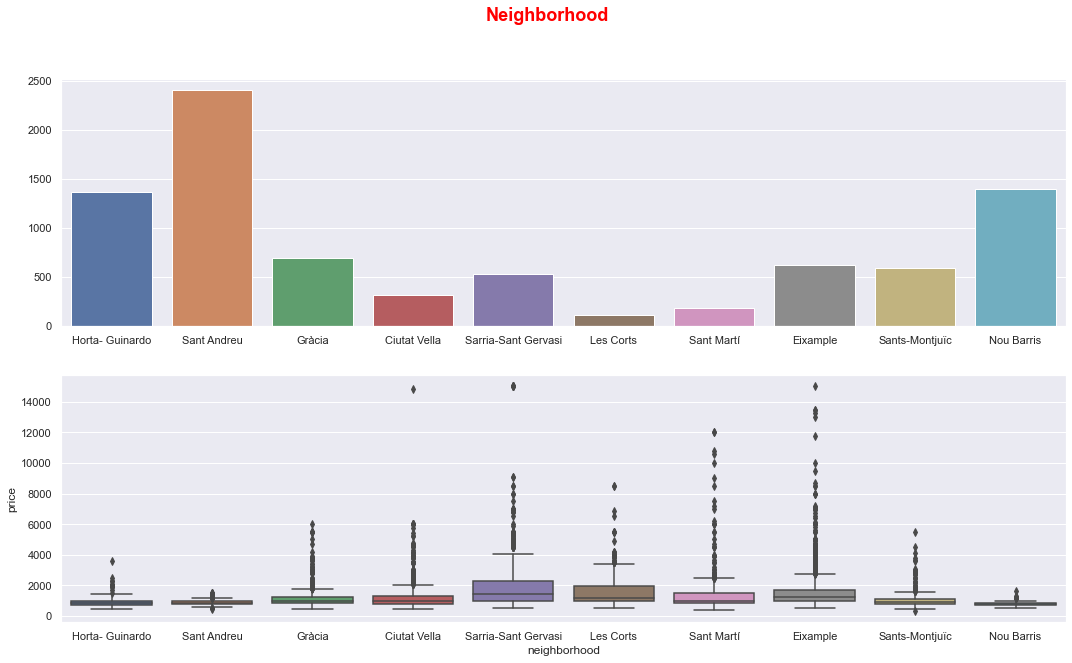

CORRELACIÓN: neighborhood y price: 0.09


In [15]:
analisis("neighborhood")

- De acuerdo a la correlación, se puede afirmar que no existe diferencia del precio de la vivienda por distrito.
- Chequear los outlayers de distritos de *Ciutat Vella*, *Sarria-Sant Gervasi* y *Eixample*.

In [16]:
main_cols=["price","real_state","neighborhood","rooms"]
for d in ["Ciutat Vella","Sarria-Sant Gervasi","Eixample"]:
    print(data[main_cols].query("neighborhood==@d").query("price>=price.quantile(.9999)"))

      price real_state  neighborhood  rooms
1487  14800  apartment  Ciutat Vella      1
      price real_state         neighborhood  rooms
1772  15000       flat  Sarria-Sant Gervasi      4
2427  15000  apartment  Sarria-Sant Gervasi      4
2754  15000       flat  Sarria-Sant Gervasi      4
4220  15000       flat  Sarria-Sant Gervasi      4
4725  15000  apartment  Sarria-Sant Gervasi      4
7646  15000  apartment  Sarria-Sant Gervasi      4
7928  15000       flat  Sarria-Sant Gervasi      4
      price real_state neighborhood  rooms
6951  15000       flat     Eixample      2


### Real state

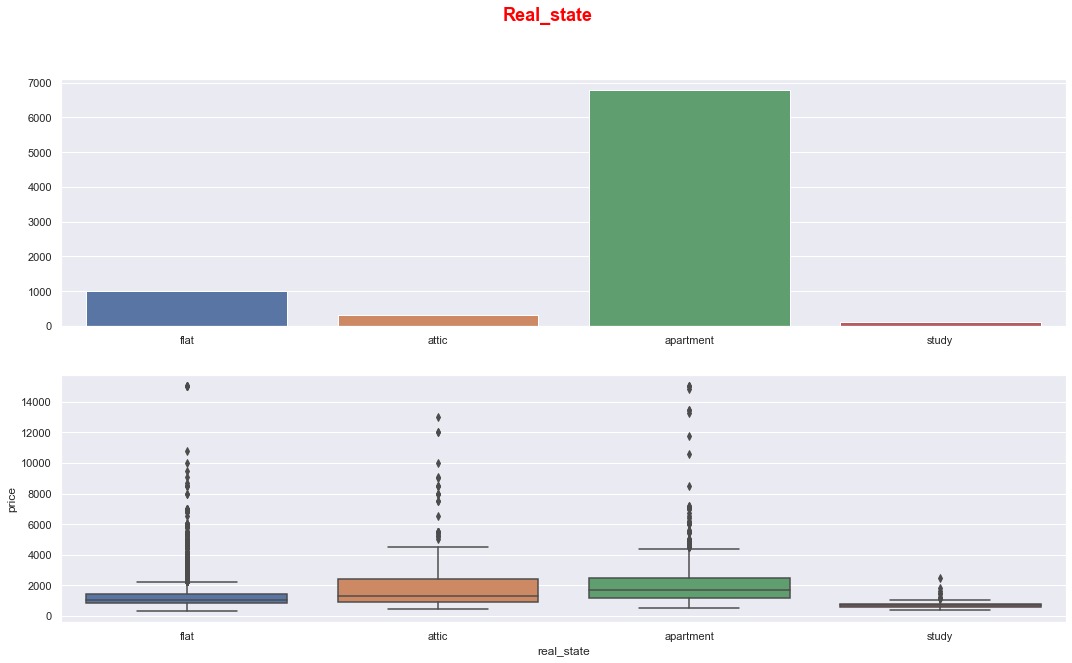

CORRELACIÓN: real_state y price: -0.25


In [17]:
analisis("real_state")

- Se puede descartar que no existe una relación entre el precio y tipo de vivienda.
- Existen outlayers en *flat* y *apartment*. 

In [18]:
for tipo_viv in ["flat","apartment"]:
    print(data[main_cols].query("real_state==@tipo_viv").query("price>=price.quantile(.9999)"))

      price real_state         neighborhood  rooms
1772  15000       flat  Sarria-Sant Gervasi      4
2754  15000       flat  Sarria-Sant Gervasi      4
4220  15000       flat  Sarria-Sant Gervasi      4
6951  15000       flat             Eixample      2
7928  15000       flat  Sarria-Sant Gervasi      4
      price real_state         neighborhood  rooms
2427  15000  apartment  Sarria-Sant Gervasi      4
4725  15000  apartment  Sarria-Sant Gervasi      4
7646  15000  apartment  Sarria-Sant Gervasi      4


### Rooms

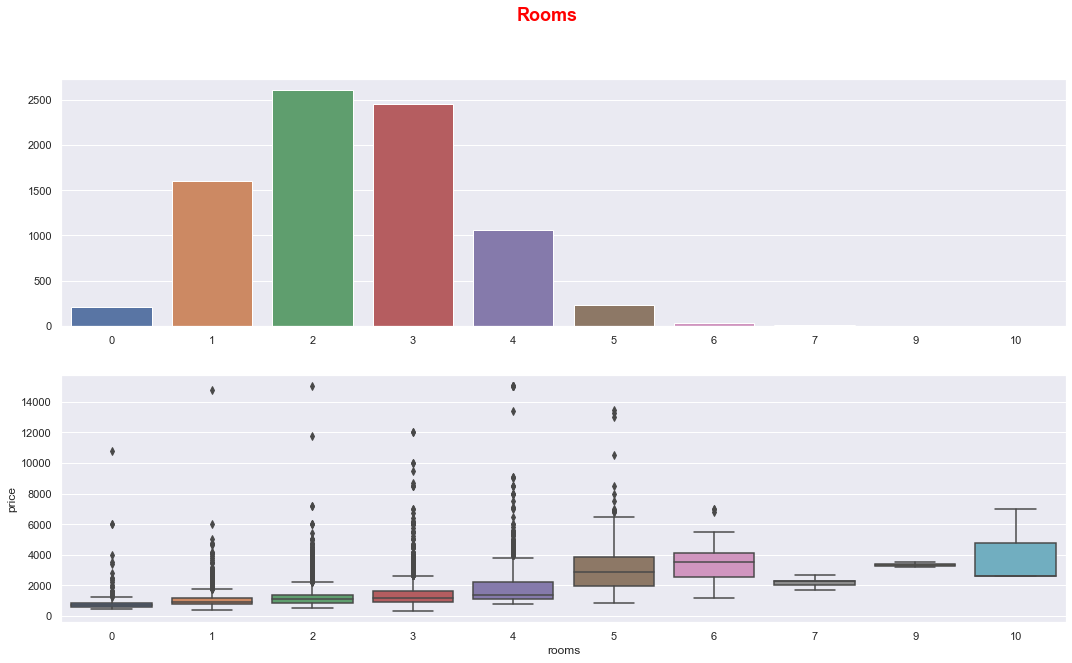

CORRELACIÓN: rooms y price: 0.35


In [19]:
analisis("rooms")

- No se puede descartar.
- Los valores que prevalece es de 2 y 3 habitaciones.
- Se debe revisar los outlayers de 1,2 y 4 habitaciones.

In [20]:
for hab in [1,2,4]:
    print(data[main_cols].query("rooms==@hab").query("price>=price.quantile(.9999)"))

      price real_state  neighborhood  rooms
1487  14800  apartment  Ciutat Vella      1
      price real_state neighborhood  rooms
6951  15000       flat     Eixample      2
      price real_state         neighborhood  rooms
1772  15000       flat  Sarria-Sant Gervasi      4
2427  15000  apartment  Sarria-Sant Gervasi      4
2754  15000       flat  Sarria-Sant Gervasi      4
4220  15000       flat  Sarria-Sant Gervasi      4
4725  15000  apartment  Sarria-Sant Gervasi      4
7646  15000  apartment  Sarria-Sant Gervasi      4
7928  15000       flat  Sarria-Sant Gervasi      4


### Bathrooms

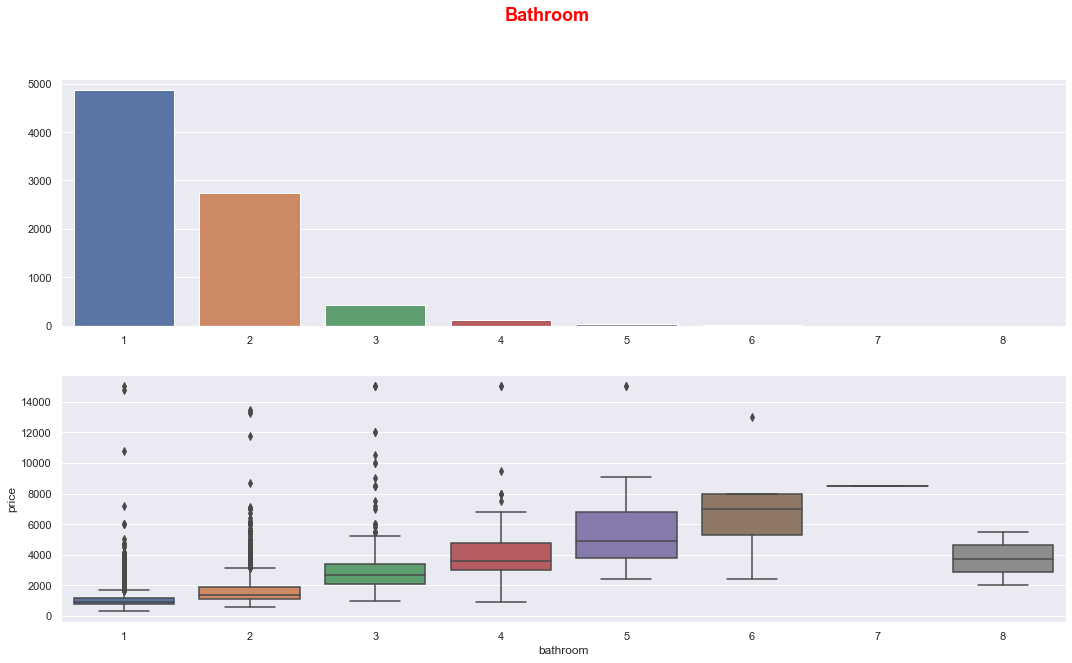

CORRELACIÓN: bathroom y price: 0.58


In [21]:
analisis("bathroom")

- La correlación es mayor que respecto a las habitaciones
- Se comprueba que la moda es de un único baño.

### Lift

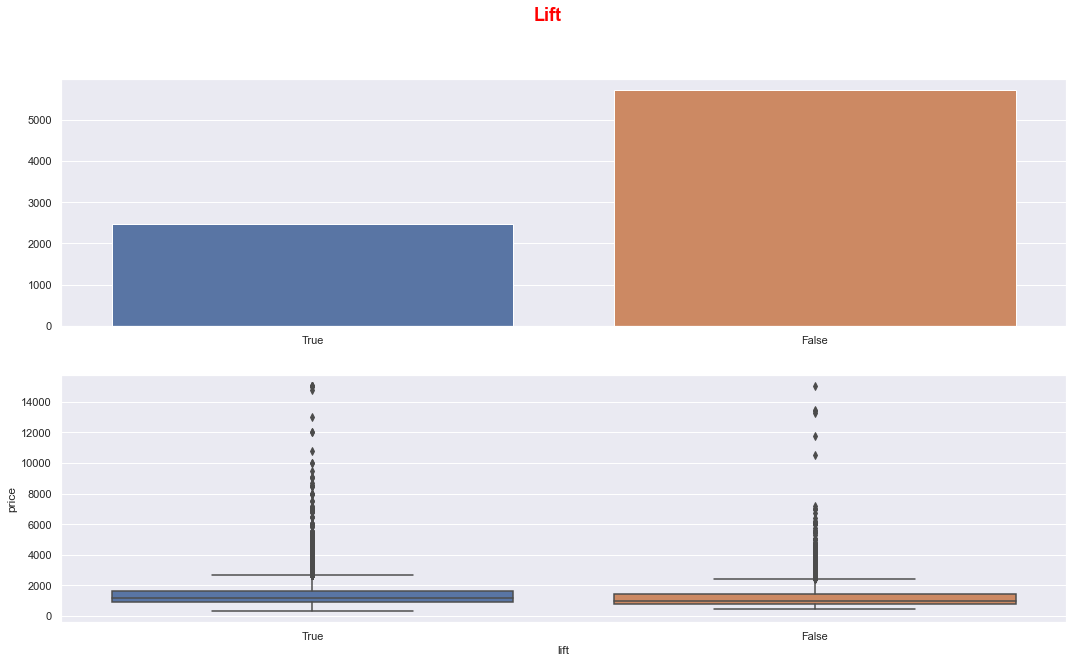

In [22]:
analisis("lift")

- Se comprueba que la mayoria de las viviendas tienen ascensores.
- No se evidencia la existencia de outlayers desde este atributo.

### Terrace

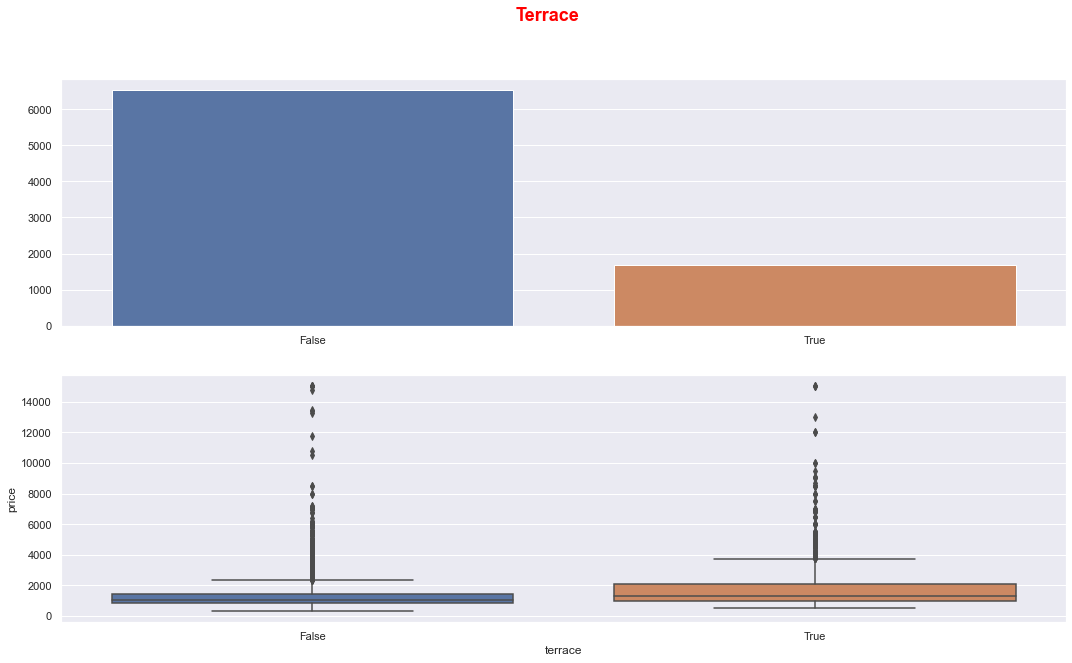

In [23]:
analisis("terrace")

- Se evidencia que análogamente en `lift`, no se aprecian outlayers desde este atributo.
- Se comprueba que la mayoria de las viviendas no tienen terrazas.

### Square meters

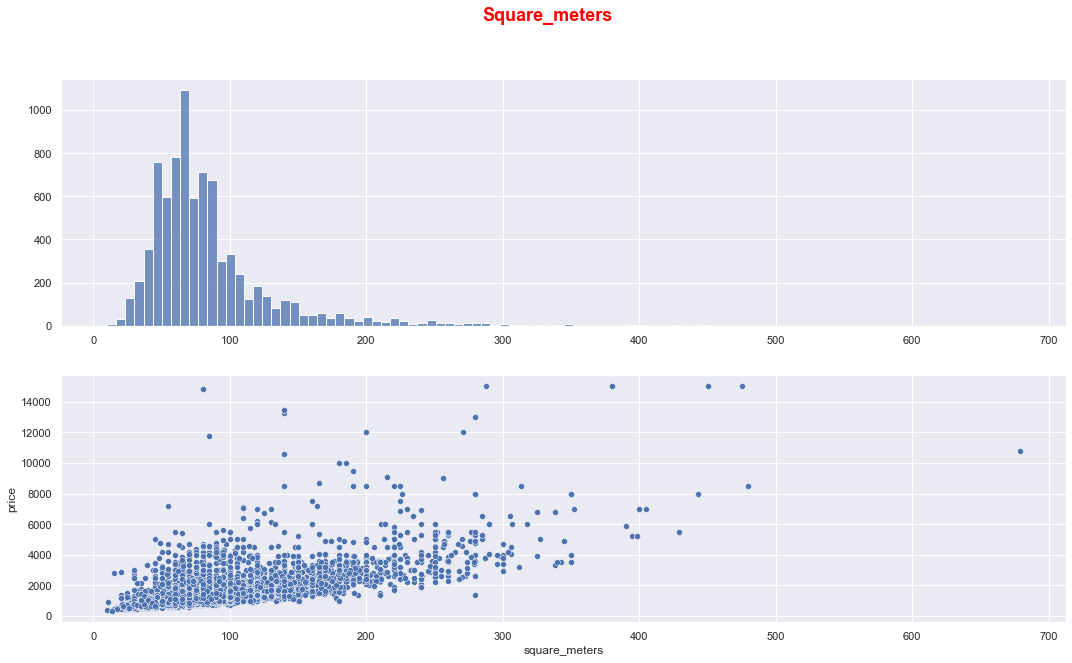

CORRELACIÓN: square_meters y price: 0.69


In [24]:
analisis("square_meters")

- Se evidencia una correlación alta.
- Se ajusta a la campana de Gauss

### Square meters price

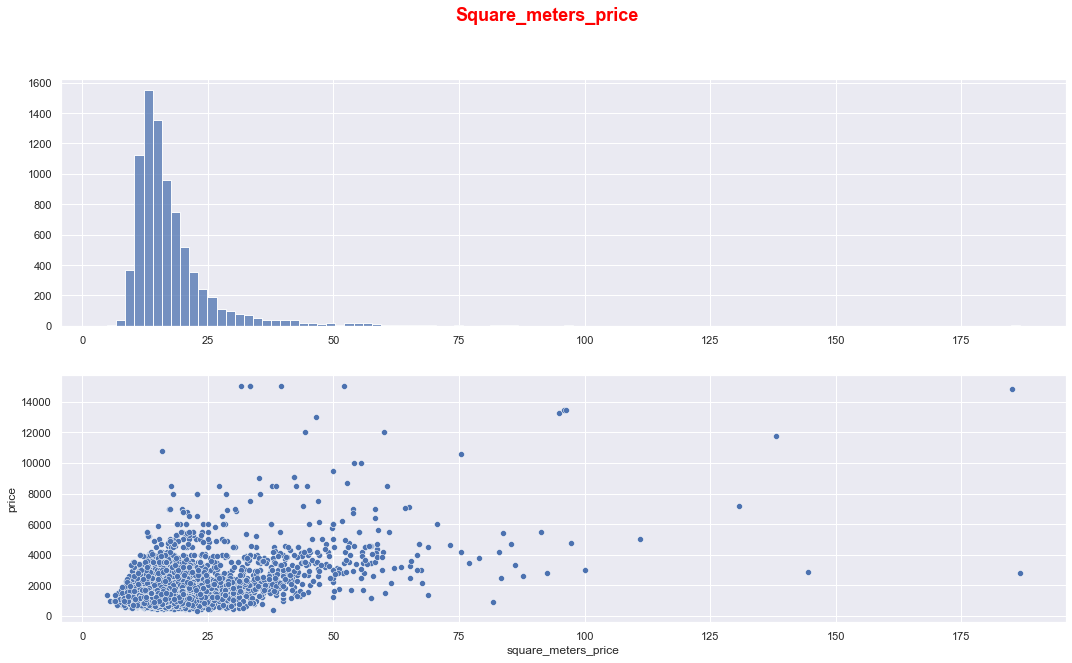

CORRELACIÓN: square_meters_price y price: 0.52


In [25]:
analisis("square_meters_price")

- La correlación es menor respecto a `square_meters`.
- Presenta un histograma asimétrico.

### Transformación de variables de categóricas a numéricas

- `real_state`
- `neighborhood`
- `lift`
- `terrace` 
  
Se considera que tanto `real_estate` y `neighborhood` no tienen jerarquia.

### Creación del dataframe procesado:

- Se considera a`bathroom` un atributo redundante porque tiene un coefiencte de correlación alto con `square-meters`.
- Se observaron que las filas las filas 6951, 1772, 2427, 2754, 4220, 4750, 7646,  7928 son outlayers. Por tanto, se decide apartarlos. 

In [26]:
cols_tranformar=["real_state","neighborhood","lift","terrace"]
for col in cols_tranformar:
    data[col]=le.fit_transform(data[col])
#A archivo csv
(data
.drop("bathroom",axis=1)
.drop([6951,1772,2427,2754,4220,4750,7646,7928],axis=0)
.to_csv("data_preprocessed.csv",index=False)
)